In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick
Warning no qutip!


# Load electrostatic potential from simulation data 

In [40]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import hbar, m_e, elementary_charge as q_e

settings_file = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6"
settings_file += r"\With L3 etch - just trap\settings.json"
fs = FullSolver(settings_file)

# x = 0.15

# mu_guess = -0.265
# def f_mu(mu):
#     return -1.755 - 7*mu

# Vtrap = np.linspace(0.20, 0.40, 61) 
# Vrg = np.linspace(-1/1.15 * (Vtrap[0] - (f_mu(mu_guess)-0.120)) - x, 
#                   -1/1.15 * (Vtrap[-1] -(f_mu(mu_guess)-0.120)), len(Vtrap))
# Vres = 0.60 * np.ones(len(Vtrap)) 
# Vtg = 0.00 * np.ones(len(Vtrap))
# Vcg = None

x = 0.40
mu_guess = -0.500
def f_mu(mu):
    return -2.86 - 6.93*mu

Vtrap = 0.52 #np.linspace(0.45, 0.70, 11) 
Vrg = -0.30 #-1/1.15 * (Vtrap - f_mu(mu_guess)) - x 
Vres = 1.00 
Vtg = 0.00 
Vcg = None

print(Vres, Vtrap, Vrg, Vtg)
# N_e = 3

# electron_positions = fs.get_trap_electron_positions(Vres, Vtrap, Vrg, Vtg, N=N_e)
# tex = electron_positions[:, ::2]
# tey = electron_positions[:, 1::2]

1.0 0.52 -0.3 0.0


In [41]:
fs.set_dc_interpolator(Vres, Vtrap, Vrg, Vtg)

In [42]:
Npts = 501

x = np.linspace(-1.5E-6, 1.5E-6, Npts)
y = np.linspace(-3E-6, 3E-6, Npts)

X, Y = np.meshgrid(x, y)

U = fs.dc_interpolator.ev(X, Y)
min_idx = np.unravel_index(np.argmin(U), np.shape(U))

print("Interpolation spacing in (x, y) direction is (%.0f nm, %.0f nm)" % (np.diff(x)[0] * 1E9, np.diff(y)[0] * 1E9))

Interpolation spacing in (x, y) direction is (6 nm, 12 nm)


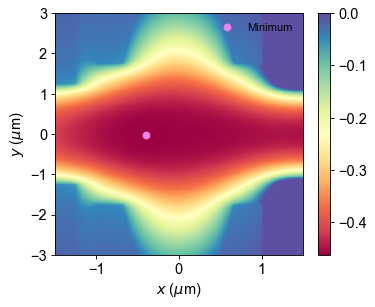

In [43]:
fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.pcolormesh(X * 1E6, Y * 1E6, U, cmap=plt.cm.Spectral, vmin=np.min(U), vmax=0.0)
plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='violet', label="Minimum")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.colorbar()
plt.ylabel("$y$ ($\mu$m)")
plt.xlabel("$x$ ($\mu$m)")

The Schrodinger equation is as follows: 
$$ \left( \frac{\hbar^2}{2m_e} \nabla^2 + V \right) \psi = E \psi $$
We can rewrite $V = e \phi$ and then work in units of eV by dividing the entire equation by $e$. This leads to 
$$ \left( \frac{\hbar^2}{2 e m_e} \nabla^2 + \phi \right) \psi = \frac{E}{e} \psi $$
$\phi$ is the electrostatic potential that we get you can get from simulation. It's positive when you apply a positive voltage on one of the electrodes. Let us know write the equation such that the kinetic terms are 1: 
$$ \left( \nabla^2 + \frac{2 e m_e}{\hbar^2} \phi \right) \psi = \frac{2 m_e e}{\hbar^2} \frac{E}{e} \psi $$

To find the proper ground state, the solver needs a guess. For this guess, we choose the potential minimum. Below is the value that is programmed in the code

In [44]:
print("The potential minimum is %.6f eV" % (np.min(U)))

The potential minimum is -0.462304 eV


Now let's solve the sparse system of equations. To get the mode frequencies, remember that the eigenvalues are given as
$$ E' = \frac{2 m_e e}{\hbar^2} \frac{E}{e} $$
Therefore, to get the eigenfrequency $f = E/h$ we have to apply the following multiplicative factors:
$$ f = \frac{E}{h} = \frac{e \hbar^2 E'}{2 e m_e h}$$

In [45]:
N_evals = 10

el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
el.sparsify(num_levels=N_evals)
Evals, Evecs = el.solve(sparse_args=el.sparse_args)

Psis = el.get_2Dpsis(N_evals)
mode_frequencies = (Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar)

In [46]:
print(tabulate(np.array([np.arange(N_evals), (mode_frequencies)/1E9, 
                np.append(np.zeros(1), np.diff(mode_frequencies)/1E9), 
                         [np.sum(Psis[i] * np.conjugate(Psis[i])) for i in range(N_evals)]]).T, 
               tablefmt="fancy_grid", headers=["n", "fn (GHz)", "fn - fn-1 (GHz)", "||<n|n>||"], 
               floatfmt=".3f", numalign="center", stralign='left'))

╒═══════╤════════════╤═══════════════════╤═════════════╕
│   n   │  fn (GHz)  │  fn - fn-1 (GHz)  │  ||<n|n>||  │
╞═══════╪════════════╪═══════════════════╪═════════════╡
│ 0.000 │   0.000    │       0.000       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 1.000 │   8.379    │       8.379       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 2.000 │   16.456   │       8.077       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 3.000 │   17.390   │       0.934       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 4.000 │   24.541   │       7.151       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 5.000 │   25.476   │       0.935       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 6.000 │   32.168   │       6.692       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 7.000 │   33.080   │       0.

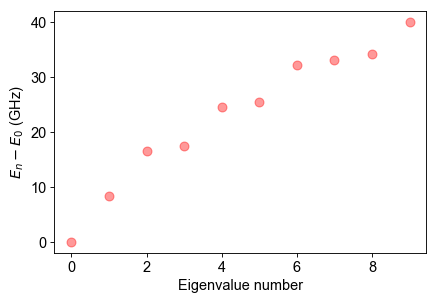

In [47]:
# plt.figure()
# plot((Evals * hbar**2 / (2 * q_e * m_e) - U[min_idx]) * 1E6, 'o', **common.plot_opt('red'))
# plt.xlabel("Eigenvalue number")
# plt.ylabel("$E_n - e\phi(x_\min, y_\min)$ ($\mu$eV)")

plt.figure()
plt.plot(mode_frequencies / 1E9, 'o', **common.plot_opt('red'))
plt.xlabel("Eigenvalue number")
plt.ylabel("$E_n - E_0$ (GHz)")

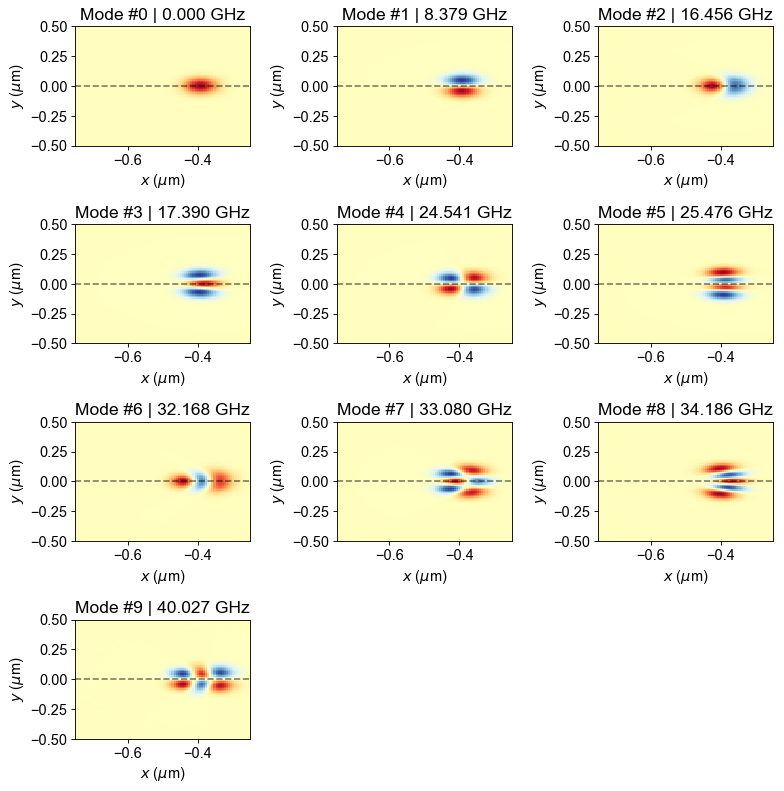

In [48]:
fig = plt.figure(figsize=(10., 12.))

for i in range(N_evals):
    max_idx = np.unravel_index(np.argmax(Psis[i]), np.shape(U))
    cmax = np.max(np.abs(Psis[i]))
    cmin = -cmax
    
    plt.subplot(5, 3, i+1)
    plt.pcolormesh(el.x * 1E6, el.y * 1E6, Psis[i], cmap=plt.cm.RdYlBu_r, vmin=cmin, vmax=cmax)
    if 0:
        plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='black', label="Classical minimum")
        plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
    plt.title("Mode #%d | %.3f GHz" % (i, (mode_frequencies[i] - mode_frequencies[0])/1E9))
    plt.hlines(0.0, -0.75, -0.25, linestyles='--', color='k', alpha=0.5)
    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
    plt.xlim(-0.75, -0.25)
    plt.ylim(-0.5, 0.5)
#     plt.colorbar()

fig.tight_layout()
# plt.show()

## Plot a 1D slice

(-0.25, -0.24)

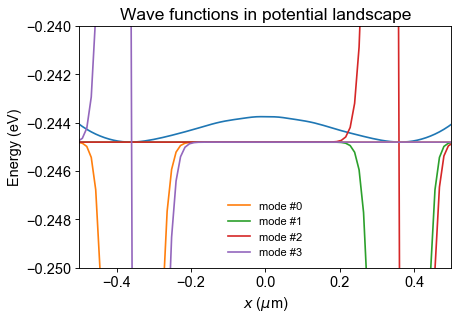

In [128]:
xoi = -0.50 * 1E-6
xoi_idx = common.find_nearest(el.x, xoi)
potential1D = fs.dc_interpolator.ev(xoi, el.y)

plt.plot(el.y * 1E6, potential1D)
for i in range(4):
    plt.plot(el.y * 1E6, Psis[i][:, xoi_idx] + np.min(potential1D), label="mode #%d"%i)

plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.xlim(-0.5, 0.5)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy (eV)")
plt.title("Wave functions in potential landscape")
plt.ylim(-0.25, -0.24)

# Calculate the coupling of all modes

## Load RF data

In [121]:
fs.set_rf_interpolator()

In [122]:
mode_contours = [0.01, 0.05, 0.10]
mode_number = 1

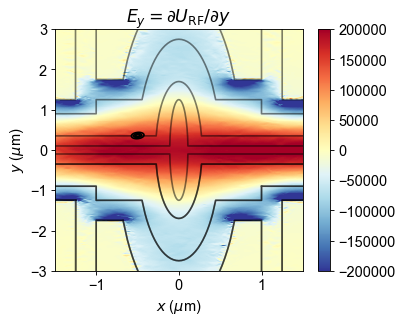

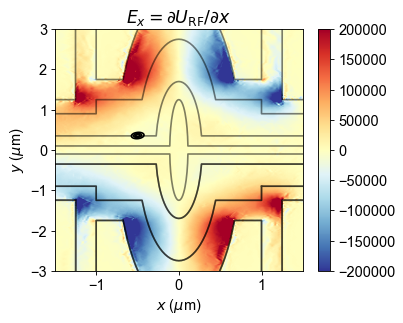

In [123]:
fig = plt.figure(figsize=(5, 4.))
plt.pcolormesh(el.x * 1E6, el.y * 1E6, fs.Ey(X, Y), cmap=plt.cm.RdYlBu_r, vmin=-2E5, vmax=2E5)
plt.colorbar()

# CS = plt.contour(Vresguards, Vtraps-0.120, Em, colors='white', levels=levels)
# plt.clabel(CS, colors='white', inline=1, fontsize=10)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)

CS = plt.contour(el.x * 1E6, el.y * 1E6, np.abs(Psis[mode_number]), colors='black', levels=mode_contours, lw=0.5)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.title("$E_y = \partial U_\mathrm{RF}/\partial y$")
plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)

fig = plt.figure(figsize=(5, 4.))
plt.pcolormesh(el.x * 1E6, el.y * 1E6, fs.Ex(X, Y), cmap=plt.cm.RdYlBu_r, vmin=-2E5, vmax=2E5)
plt.colorbar()
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)

CS = plt.contour(el.x * 1E6, el.y * 1E6, np.abs(Psis[mode_number]), colors='black', levels=mode_contours, lw=0.5)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.title("$E_x = \partial U_\mathrm{RF}/\partial x$")

## Calculate $g_{ij}$ and transition dipole moment

The coupling matrix tells us something about how strongly a specific transition couples to the resonator mode. It's given by 
$$ g_{ij} = \langle \psi_i | \mathbf{d} \cdot \mathbf{E} | \psi_j \rangle = e \sqrt{\frac{\hbar \omega_0^2 Z_0}{2}} \iint \psi_i (x,y) (x E_x + y E_y) \psi_j^* (x,y) dx dy $$
where $E_{x,y}$ are the electric fields in the $x,y$ direction determined from electrostatic simulation where $\pm0.5$V was applied to the resonator pins. The prefactor turns that into a single photon coupling.

In [124]:
omega0 = 2 * np.pi * 6.5E9
Z0 = 100

gij = np.zeros((N_evals, N_evals))
rij = np.zeros((N_evals, N_evals))

prefactor = q_e * np.sqrt(hbar * omega0**2 * Z0 / 2) * 1 / (2 * np.pi * hbar)

for i in trange(N_evals):
    for j in range(N_evals):
        gij[i, j] = prefactor * np.sum(Psis[i] * ( X * fs.Ex(X, Y) + Y * fs.Ey(X, Y) ) * np.conjugate(Psis[j]))
        rij[i, j] = np.sum(Psis[i] * Y * np.conjugate(Psis[j]))

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


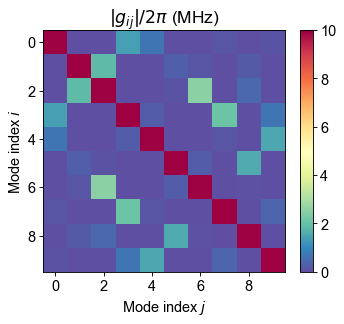

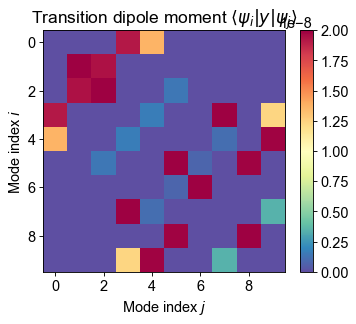

In [126]:
fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.imshow(np.abs(gij)/1E6, cmap=plt.cm.Spectral_r)
plt.xlabel("Mode index $j$")
plt.ylabel("Mode index $i$")
plt.title("$|g_{ij}|/2\pi$ (MHz)")
plt.clim(0, 10)
plt.colorbar()

fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.imshow(rij, cmap=plt.cm.Spectral_r)
plt.xlabel("Mode index $j$")
plt.ylabel("Mode index $i$")
plt.title(r"Transition dipole moment $\langle \psi_i | y | \psi_j \rangle $")
plt.colorbar()
plt.clim(0, 0.2E-7)

The diagonal elements of the coupling matrix ($g_{ii}$) are the expectation values of $x + y$, of state $|\psi_i\rangle$ and thus tell you something about the size of the wavefunction.

# Dependence on potential spacing

In [66]:
mode_frequency_dependency = list()
evaluation_points = np.arange(101, 801, 50)

for Npts in evaluation_points:

    x = np.linspace(-1.5E-6, 1.5E-6, Npts)
    y = np.linspace(-3E-6, 3E-6, Npts)

    X, Y = np.meshgrid(x, y)

    U = fs.dc_interpolator.ev(X, Y)
    min_idx = np.unravel_index(np.argmin(U), np.shape(U))

    print("Interpolation spacing in (x, y) direction is (%.0f nm, %.0f nm)" % (np.diff(x)[0] * 1E9, np.diff(y)[0] * 1E9))
    
    N_evals = 10

    el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
    el.sparsify(num_levels=N_evals)
    Evals, Evecs = el.solve(sparse_args=el.sparse_args)

    Psis = el.get_2Dpsis(N_evals)
    mode_frequency_dependency.append((Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar))
    
mode_frequency_dependency = np.array(mode_frequency_dependency)

Interpolation spacing in (x, y) direction is (30 nm, 60 nm)
Interpolation spacing in (x, y) direction is (20 nm, 40 nm)
Interpolation spacing in (x, y) direction is (15 nm, 30 nm)
Interpolation spacing in (x, y) direction is (12 nm, 24 nm)
Interpolation spacing in (x, y) direction is (10 nm, 20 nm)
Interpolation spacing in (x, y) direction is (9 nm, 17 nm)
Interpolation spacing in (x, y) direction is (7 nm, 15 nm)
Interpolation spacing in (x, y) direction is (7 nm, 13 nm)
Interpolation spacing in (x, y) direction is (6 nm, 12 nm)
Interpolation spacing in (x, y) direction is (5 nm, 11 nm)
Interpolation spacing in (x, y) direction is (5 nm, 10 nm)
Interpolation spacing in (x, y) direction is (5 nm, 9 nm)
Interpolation spacing in (x, y) direction is (4 nm, 9 nm)
Interpolation spacing in (x, y) direction is (4 nm, 8 nm)


(0.0, 13)

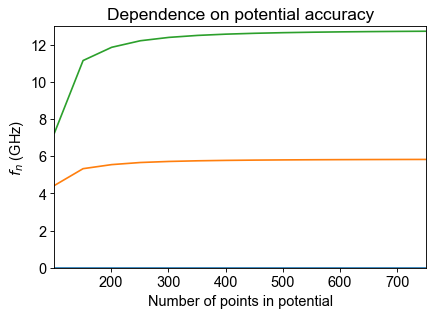

In [67]:
plt.plot(evaluation_points, mode_frequency_dependency/1e9)
plt.xlim(np.min(evaluation_points), np.max(evaluation_points))
plt.xlabel("Number of points in potential")
plt.ylabel("$f_n$ (GHz)")
plt.title("Dependence on potential accuracy")
plt.ylim(0., 13)

(0, 0.05)

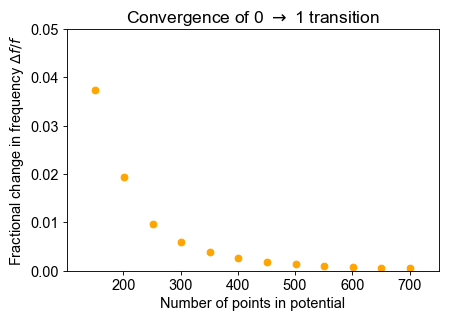

In [87]:
plt.plot(evaluation_points[:-1], np.abs(np.diff(mode_frequency_dependency[:,1]))/mode_frequency_dependency[-1, 1], 
         'o', color='orange')
# plt.plot(evaluation_points[:-1], np.abs(np.diff(mode_frequency_dependency[:,2]))/mode_frequency_dependency[-1, 2], 
#          'o', color='forestgreen')
plt.xlim(np.min(evaluation_points), np.max(evaluation_points))
plt.xlabel("Number of points in potential")
plt.ylabel("Fractional change in frequency $\Delta f/f$")
plt.title(r"Convergence of 0 $\rightarrow$ 1 transition")
plt.ylim(0, 0.05)
# plt.ylim(0., 13)

# Comparison with 2D harmonic oscillator potential

<img src="HarmonicOscillator2D.png"><img>

In [91]:
def psi00(x, y, alpha):
    return np.sqrt(alpha/np.pi) * np.e ** (-alpha/2. * (x**2 + y**2))

def psi10(x, y, alpha):
    return (4 * alpha**3 / np.pi) ** (1/4.) * (alpha/np.pi) ** (1/4.) * x * np.e ** (-alpha/2. * (x**2 + y**2))

def psi11(x, y, alpha):
    return np.sqrt(4 * alpha **3 / np.pi) * x * y * np.e ** (-alpha/2. * (x**2 + y**2))

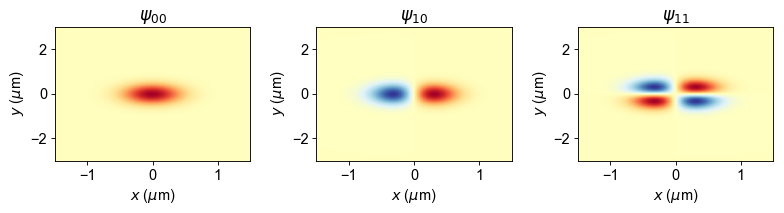

In [108]:
fig = plt.figure(figsize=(10., 12.))
wavefunctions = ["$\psi_{00}$", "$\psi_{10}$", "$\psi_{11}$"]
alpha = 1E13 # This is a proxy for the curvature
i = 0
for wf_str, wavefunction in zip(wavefunctions, [psi00, psi10, psi11]):
    
    cmax = np.max(np.abs(wavefunction(X, Y, alpha)))
    cmin = -cmax
    
    plt.subplot(5, 3, i+1)
    plt.pcolormesh(el.x * 1E6, el.y * 1E6, wavefunction(X, Y, alpha), cmap=plt.cm.RdYlBu_r, vmin=cmin, vmax=cmax)
    
    plt.title("%s" % wf_str)
    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
#     plt.xlim(-0.75, -0.25)
#     plt.ylim(-0.25, 0.25)
#     plt.colorbar()
    i += 1

fig.tight_layout()

# Temperature dependence / thermal occupancy

In [66]:
from scipy.constants import Boltzmann as kB

fs = np.linspace(0, 10E9, 1E3)
T = 20E-3

def Z(f, N_levels=20):
    z = np.zeros(len(f))
    for n in range(N_levels):
        z += np.exp(-2*np.pi*hbar*n*f/(kB*T))
    return z

g_state = 1 / Z(fs)
e_state = np.exp(-2*np.pi*hbar*1*fs/(kB*T)) / Z(fs)
f_state = np.exp(-2*np.pi*hbar*2*fs/(kB*T)) / Z(fs)
h_state = np.exp(-2*np.pi*hbar*3*fs/(kB*T)) / Z(fs)

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


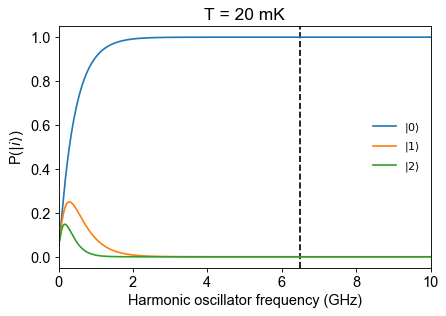

In [67]:
fig = plt.figure()
common.configure_axes(13)

plt.plot(fs/1E9, g_state, label=r'$|0\rangle$')
plt.plot(fs/1E9, e_state, label=r'$|1\rangle$')
plt.plot(fs/1E9, f_state, label=r'$|2\rangle$')
# plt.plot(fs/1E9, h_state)

plt.vlines(6.5, -0.05, 1.05, linestyles='--', color='k')
plt.legend(loc=0, prop={"size" : 10}, frameon=False)
plt.ylabel(r"P($|i\rangle$)")
plt.xlabel("Harmonic oscillator frequency (GHz)")
plt.xlim(np.min(fs/1E9), np.max(fs/1E9))
plt.ylim(-0.05, 1.05)
plt.title("T = %.0f mK" % (T * 1E3))
# plt.plot(fs, Z(fs))

# common.save_figure(fig, save_path=r"C:\Users\Gerwin\Documents\Code\iPythonNotebooks\Figures")